# CNN + MaxPool

Use GlobalMaxPooling (one conv, one pool).

The model hits 60% validation accuracy sometimes. There is less overfitting than usual.

Not predicting enough cyto=1. Could lower the score threshold. Or use GMM instead of -1 RCI threshold.

In [48]:
from datetime import datetime
print(datetime.now())

2023-03-21 16:38:17.427801


In [49]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [50]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [51]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [52]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [53]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [54]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = GlobalMaxPooling1D()
    #pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [55]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 16:38:19.904619
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_107 (Conv1D)         (None, 4990, 64)          2112      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_35 (Flatten)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
________________________

## Training

In [56]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [57]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 16:38:20.087169
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 16:38:26.310644

Training # 1 1
2023-03-21 16:38:26.310788
2023-03-21 16:38:26.319618
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 16:38:28.102951


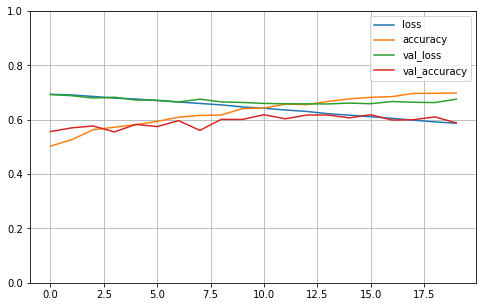


2023-03-21 16:38:54.872922

Testing # 1 1
2023-03-21 16:38:54.874449
2023-03-21 16:38:54.874797
PREDICT
2023-03-21 16:38:55.320749
Test 1:0 458:412 52.64%
Predict 1:0 300:570 34.48%
Test sizes (870, 4997) (870,)
Range of scores: 0.114806 to 0.9043037
Score threshold 0.5
Confusion matrix
 [[312 100]
 [258 200]]
Normalized matrix
 [[0.35862069 0.11494253]
 [0.29655172 0.22988506]]


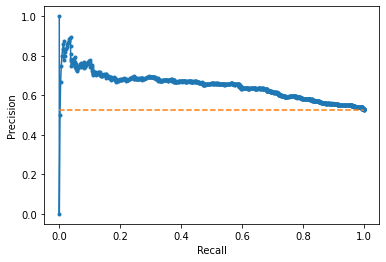

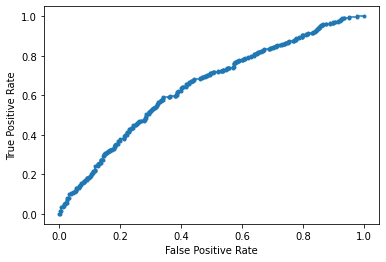

Accuracy: 58.85% Precision: 66.67% Recall: 43.67%
F1: 52.77% MCC: 0.2038
AUPRC: 64.99% AUROC: 64.51%
 accuracy [58.85057471264368]
 precision [66.66666666666666]
 recall [43.66812227074236]
 F1 [52.770448548812666]
 MCC [0.20375190747086372]
 AUPRC [64.98760296542295]
 AUROC [64.50640183151735]
2023-03-21 16:38:56.185264

Training # 1 2
2023-03-21 16:38:56.187042
2023-03-21 16:38:56.187442
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 16:38:57.984486


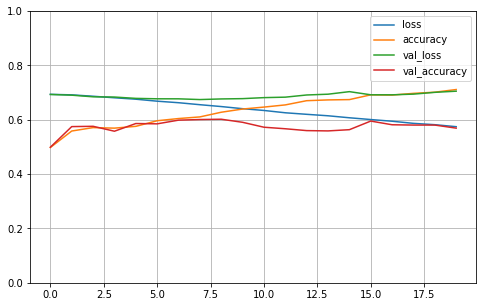


2023-03-21 16:39:24.170113

Testing # 1 2
2023-03-21 16:39:24.170211
2023-03-21 16:39:24.170249
PREDICT
2023-03-21 16:39:24.407046
Test 1:0 442:442 50.00%
Predict 1:0 507:377 57.35%
Test sizes (884, 4997) (884,)
Range of scores: 0.14694655 to 0.9429174
Score threshold 0.5
Confusion matrix
 [[219 223]
 [158 284]]
Normalized matrix
 [[0.24773756 0.25226244]
 [0.17873303 0.32126697]]


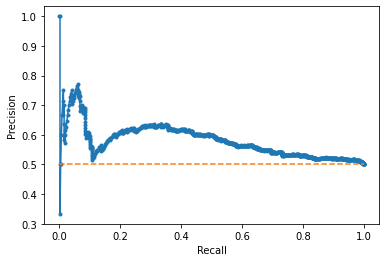

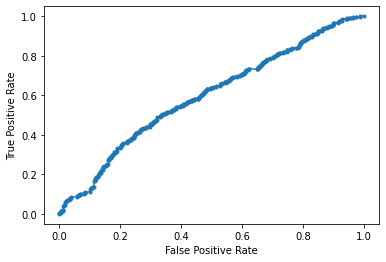

Accuracy: 56.90% Precision: 56.02% Recall: 64.25%
F1: 59.85% MCC: 0.1395
AUPRC: 58.10% AUROC: 59.62%
 accuracy [56.90045248868778]
 precision [56.01577909270217]
 recall [64.25339366515837]
 F1 [59.85247629083245]
 MCC [0.1395260116940508]
 AUPRC [58.09844985242063]
 AUROC [59.623574455887464]
2023-03-21 16:39:25.062200

Training # 1 3
2023-03-21 16:39:25.063758
2023-03-21 16:39:25.063823
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 16:39:26.276162


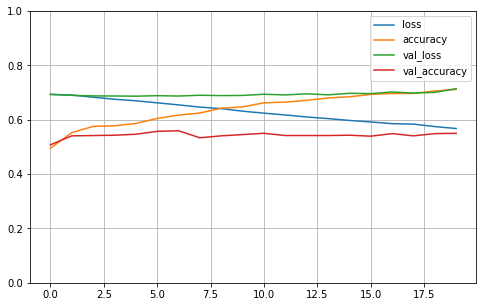


2023-03-21 16:40:08.273677

Testing # 1 3
2023-03-21 16:40:08.273764
2023-03-21 16:40:08.273797
PREDICT
2023-03-21 16:40:08.490597
Test 1:0 442:407 52.06%
Predict 1:0 544:305 64.08%
Test sizes (849, 4997) (849,)
Range of scores: 0.13100216 to 0.9683418
Score threshold 0.5
Confusion matrix
 [[165 242]
 [140 302]]
Normalized matrix
 [[0.19434629 0.28504122]
 [0.16489988 0.3557126 ]]


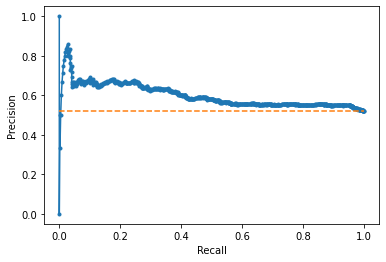

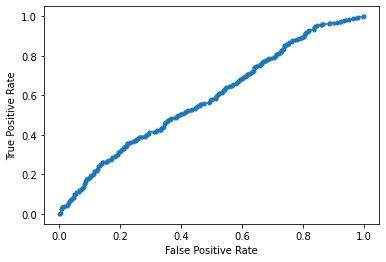

Accuracy: 55.01% Precision: 55.51% Recall: 68.33%
F1: 61.26% MCC: 0.0923
AUPRC: 59.86% AUROC: 58.71%
 accuracy [55.005889281507656]
 precision [55.51470588235294]
 recall [68.32579185520362]
 F1 [61.25760649087222]
 MCC [0.09232152688789179]
 AUPRC [59.86214834142951]
 AUROC [58.705126352185175]
2023-03-21 16:40:09.954176

Training # 1 4
2023-03-21 16:40:09.954856
2023-03-21 16:40:09.954907
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 16:40:11.139000


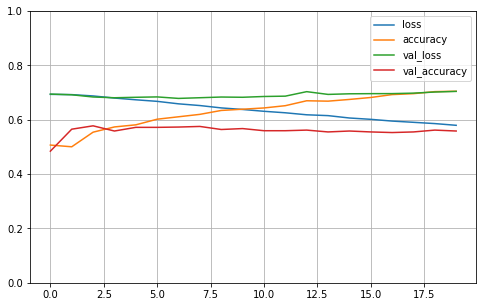


2023-03-21 16:40:39.139990

Testing # 1 4
2023-03-21 16:40:39.141459
2023-03-21 16:40:39.141791
PREDICT
2023-03-21 16:40:39.809466
Test 1:0 459:431 51.57%
Predict 1:0 400:490 44.94%
Test sizes (890, 4997) (890,)
Range of scores: 0.07090641 to 0.9515389
Score threshold 0.5
Confusion matrix
 [[264 167]
 [226 233]]
Normalized matrix
 [[0.29662921 0.18764045]
 [0.25393258 0.26179775]]


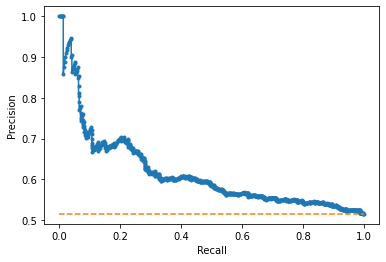

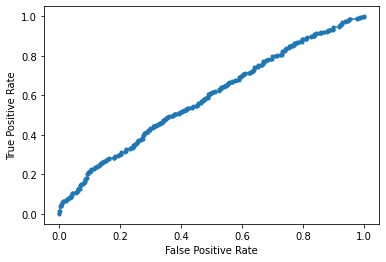

Accuracy: 55.84% Precision: 58.25% Recall: 50.76%
F1: 54.25% MCC: 0.1207
AUPRC: 61.51% AUROC: 58.86%
 accuracy [55.842696629213485]
 precision [58.25]
 recall [50.76252723311547]
 F1 [54.249126891734576]
 MCC [0.12071359062484492]
 AUPRC [61.51225514046394]
 AUROC [58.86194642848117]
2023-03-21 16:40:41.834753

Training # 1 5
2023-03-21 16:40:41.836993
2023-03-21 16:40:41.837451
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 16:40:44.900984


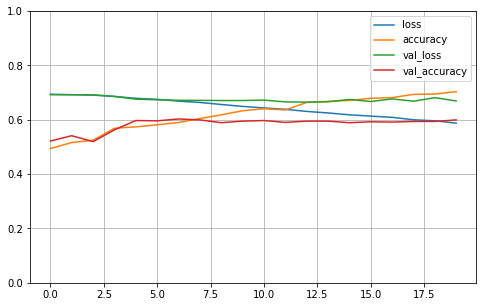


2023-03-21 16:41:27.539666

Testing # 1 5
2023-03-21 16:41:27.542258
2023-03-21 16:41:27.542707
PREDICT
2023-03-21 16:41:27.793046
Test 1:0 457:419 52.17%
Predict 1:0 456:420 52.05%
Test sizes (876, 4997) (876,)
Range of scores: 0.14651166 to 0.89574057
Score threshold 0.5
Confusion matrix
 [[244 175]
 [176 281]]
Normalized matrix
 [[0.27853881 0.19977169]
 [0.20091324 0.32077626]]


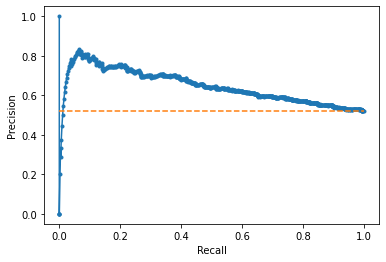

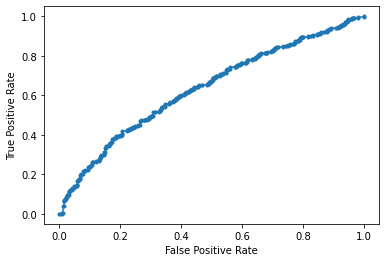

Accuracy: 59.93% Precision: 61.62% Recall: 61.49%
F1: 61.56% MCC: 0.1972
AUPRC: 64.52% AUROC: 63.49%
 accuracy [59.93150684931506]
 precision [61.622807017543856]
 recall [61.48796498905909]
 F1 [61.5553121577218]
 MCC [0.19719950066300634]
 AUPRC [64.52116149727503]
 AUROC [63.49179822751889]
2023-03-21 16:41:28.475487

Training # 2 1
2023-03-21 16:41:28.477051
2023-03-21 16:41:28.477112
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 16:41:29.669945


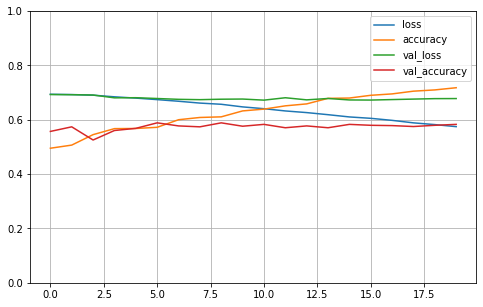


2023-03-21 16:41:55.845485

Testing # 2 1
2023-03-21 16:41:55.845581
2023-03-21 16:41:55.845616
PREDICT
2023-03-21 16:41:56.074855
Test 1:0 472:415 53.21%
Predict 1:0 468:419 52.76%
Test sizes (887, 4997) (887,)
Range of scores: 0.17992629 to 0.9682636
Score threshold 0.5
Confusion matrix
 [[232 183]
 [187 285]]
Normalized matrix
 [[0.26155581 0.20631342]
 [0.210823   0.32130778]]


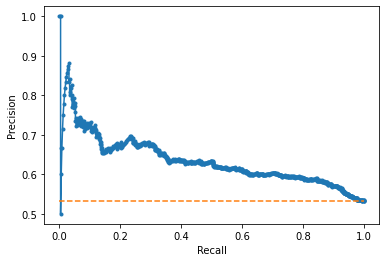

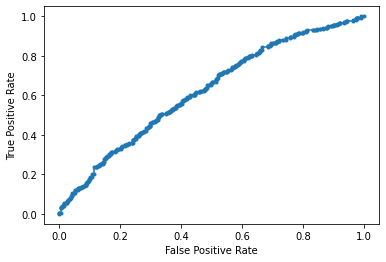

Accuracy: 58.29% Precision: 60.90% Recall: 60.38%
F1: 60.64% MCC: 0.1628
AUPRC: 63.55% AUROC: 62.15%
 accuracy [58.286358511837655]
 precision [60.89743589743589]
 recall [60.381355932203384]
 F1 [60.63829787234042]
 MCC [0.16276164963626966]
 AUPRC [63.55269476875457]
 AUROC [62.150296099652834]
2023-03-21 16:41:56.716530

Training # 2 2
2023-03-21 16:41:56.717178
2023-03-21 16:41:56.717225
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 16:41:57.911832


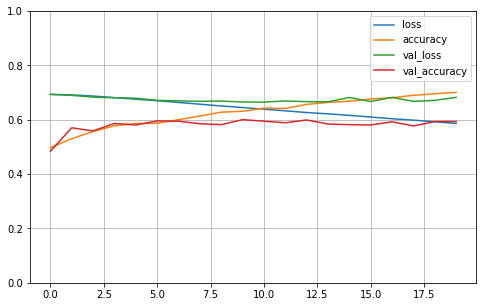


2023-03-21 16:42:23.860827

Testing # 2 2
2023-03-21 16:42:23.860933
2023-03-21 16:42:23.860975
PREDICT
2023-03-21 16:42:24.093358
Test 1:0 452:416 52.07%
Predict 1:0 313:555 36.06%
Test sizes (868, 4997) (868,)
Range of scores: 0.096245274 to 0.8858153
Score threshold 0.5
Confusion matrix
 [[309 107]
 [246 206]]
Normalized matrix
 [[0.35599078 0.12327189]
 [0.28341014 0.23732719]]


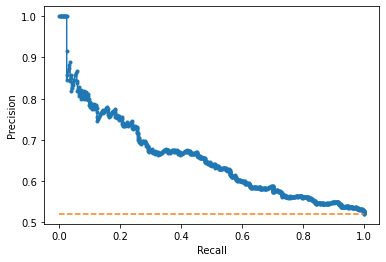

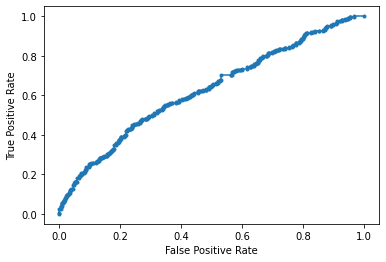

Accuracy: 59.33% Precision: 65.81% Recall: 45.58%
F1: 53.86% MCC: 0.2066
AUPRC: 65.55% AUROC: 62.71%
 accuracy [59.331797235023046]
 precision [65.814696485623]
 recall [45.57522123893805]
 F1 [53.8562091503268]
 MCC [0.2065602326650601]
 AUPRC [65.55260280482061]
 AUROC [62.711134275017024]
2023-03-21 16:42:24.740677

Training # 2 3
2023-03-21 16:42:24.742796
2023-03-21 16:42:24.742871
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 16:42:25.947797


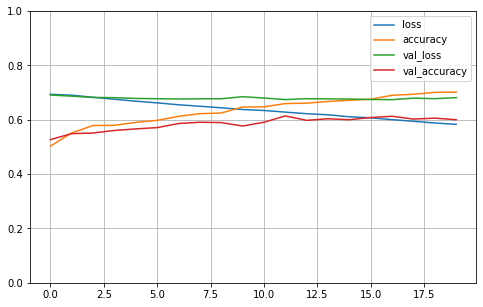


2023-03-21 16:42:52.312198

Testing # 2 3
2023-03-21 16:42:52.312299
2023-03-21 16:42:52.312342
PREDICT
2023-03-21 16:42:52.534462
Test 1:0 453:407 52.67%
Predict 1:0 351:509 40.81%
Test sizes (860, 4997) (860,)
Range of scores: 0.07694251 to 0.9033927
Score threshold 0.5
Confusion matrix
 [[286 121]
 [223 230]]
Normalized matrix
 [[0.33255814 0.14069767]
 [0.25930233 0.26744186]]


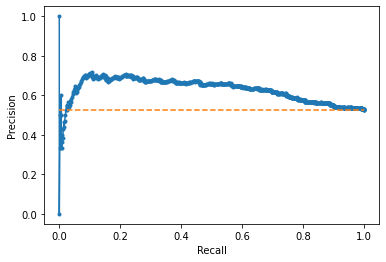

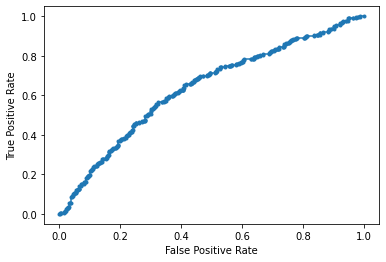

Accuracy: 60.00% Precision: 65.53% Recall: 50.77%
F1: 57.21% MCC: 0.2138
AUPRC: 62.88% AUROC: 63.69%
 accuracy [60.0]
 precision [65.52706552706553]
 recall [50.77262693156733]
 F1 [57.21393034825872]
 MCC [0.21376637360534628]
 AUPRC [62.87937948351505]
 AUROC [63.68680540865972]
2023-03-21 16:42:53.321487

Training # 2 4
2023-03-21 16:42:53.322954
2023-03-21 16:42:53.323312
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:42:55.568882


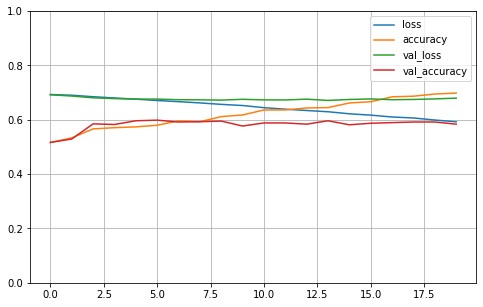


2023-03-21 16:43:37.887721

Testing # 2 4
2023-03-21 16:43:37.888147
2023-03-21 16:43:37.888183
PREDICT
2023-03-21 16:43:38.125897
Test 1:0 432:447 49.15%
Predict 1:0 342:537 38.91%
Test sizes (879, 4997) (879,)
Range of scores: 0.09408319 to 0.89559907
Score threshold 0.5
Confusion matrix
 [[309 138]
 [228 204]]
Normalized matrix
 [[0.35153584 0.15699659]
 [0.25938567 0.23208191]]


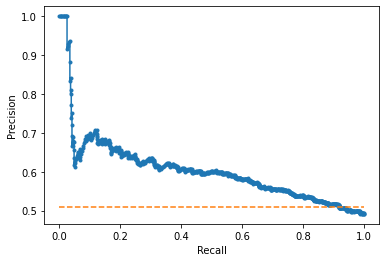

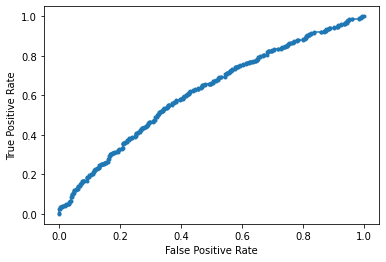

Accuracy: 58.36% Precision: 59.65% Recall: 47.22%
F1: 52.71% MCC: 0.1677
AUPRC: 60.46% AUROC: 61.76%
 accuracy [58.36177474402731]
 precision [59.64912280701754]
 recall [47.22222222222222]
 F1 [52.71317829457364]
 MCC [0.16765104440971174]
 AUPRC [60.4588653946214]
 AUROC [61.758948545861294]
2023-03-21 16:43:38.809798

Training # 2 5
2023-03-21 16:43:38.809942
2023-03-21 16:43:38.809987
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:43:40.059531


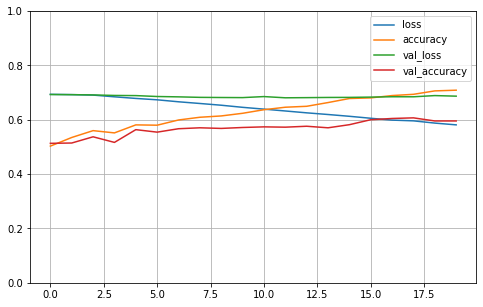


2023-03-21 16:44:22.973144

Testing # 2 5
2023-03-21 16:44:22.973237
2023-03-21 16:44:22.973273
PREDICT
2023-03-21 16:44:23.197405
Test 1:0 449:426 51.31%
Predict 1:0 431:444 49.26%
Test sizes (875, 4997) (875,)
Range of scores: 0.15826051 to 0.94909173
Score threshold 0.5
Confusion matrix
 [[258 168]
 [186 263]]
Normalized matrix
 [[0.29485714 0.192     ]
 [0.21257143 0.30057143]]


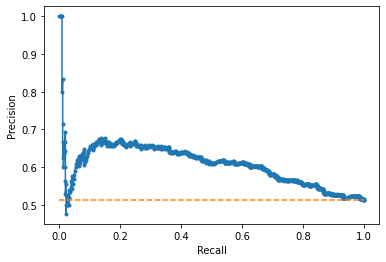

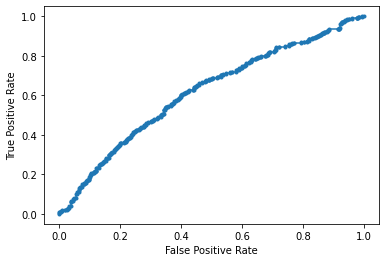

Accuracy: 59.54% Precision: 61.02% Recall: 58.57%
F1: 59.77% MCC: 0.1913
AUPRC: 60.79% AUROC: 61.66%
 accuracy [59.542857142857144]
 precision [61.02088167053365]
 recall [58.57461024498887]
 F1 [59.772727272727266]
 MCC [0.19133489623395553]
 AUPRC [60.78739694946095]
 AUROC [61.65762205004339]
2023-03-21 16:44:24.006563


In [58]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [59]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.21% std 1.74
 precision mean 61.10% std 3.95
 recall mean 55.10% std 8.57
 F1 mean 57.39% std 3.65
 MCC mean 0.17% std 0.04
 AUPRC mean 62.22% std 2.46
 AUROC mean 61.72% std 2.04
 accuracy [[58.85057471264368], [56.90045248868778], [55.005889281507656], [55.842696629213485], [59.93150684931506], [58.286358511837655], [59.331797235023046], [60.0], [58.36177474402731], [59.542857142857144]]
 precision [[66.66666666666666], [56.01577909270217], [55.51470588235294], [58.25], [61.622807017543856], [60.89743589743589], [65.814696485623], [65.52706552706553], [59.64912280701754], [61.02088167053365]]
 recall [[43.66812227074236], [64.25339366515837], [68.32579185520362], [50.76252723311547], [61.48796498905909], [60.381355932203384], [45.57522123893805], [50.77262693156733], [47.22222222222222], [58.57461024498887]]
 F1 [[52.770448548812666], [59.85247629083245], [61.25760649087222], [54.249126891734576], [61.5553121577218], [60.63829787234042], [53.8562091503268], [57.2139